## Questão 3

## Bitset

In [9]:
import numpy as np
import random

class BitSet:
    def __init__(self, size):
        self.bits = np.full((1, size), False)

    def get(self, index):
        return self.bits[0, index]

    def set(self, index, value):
        self.bits[0, index] = value

    def flip(self, index):
        self.bits[0, index] = not self.bits[0, index]

    def debug(self):
        print(self.bits)

## Cromossomo

In [10]:
class Chromossome:
    def __init__(self, x = None, y = None):
        if x == None:
            x = random.randint(-15, 15)

        if y == None:
            y = random.randint(-15, 15)

        self.__genes = Chromossome.get_genotype(x, y)

    def get_genes(self):
        return self.__genes

    def set_genes(self, genes):
        self.__genes = genes

    def to_string(self):
        chr_str = "G = ["

        for i in range(10):
            chr_str += (i == 5 and " " or "") + (self.__genes.get(i) and "1" or "0")

        x, y = Chromossome.get_fenotype(self.__genes)

        chr_str += "], F = [" + str(x) + ", " + str(y) + "]"

        return chr_str

    @staticmethod
    def get_genotype(x, y):
        bits = BitSet(10)

        xy_binary = "{:05b}".format(x) + "{:05b}".format(y)

        for i in range(10):
            bits.set(i, xy_binary[i] == '1')

        return bits

    @staticmethod
    def get_fenotype(genes):

        # XXXXX YYYYY (5 bits to each variable: 4 for value and 1 for sign pos/neg)
        # 01234 56789 (bits are indexed from left to right, adopting little-endian)
        # 8421K 8421K (bits on indices 4 and 9 represent the variables sign, i.e.
        #              0 represents a positive and 1 represents a negative value;
        #              https://en.wikipedia.org/wiki/Sign_bit for more information)

        x = (8 * genes.get(0) +
            4 * genes.get(1) +
            2 * genes.get(2) +
            1 * genes.get(3))

        if (genes.get(4) == 1):
            x *= -1

        y = (8 * genes.get(5) +
            4 * genes.get(6) +
            2 * genes.get(7) +
            1 * genes.get(8))

        if (genes.get(9) == 1):
            y *= -1

        return x, y

## Problema

In [11]:
class Problem:

    @staticmethod
    def f(x, y):
        return (x + 2*y-7)**2 + (2*x +y -5)**2

    @staticmethod
    def f_chromossome(chromossome):
        x, y = Chromossome.get_fenotype(chromossome.get_genes())
        return Problem.f(x, y)

    @staticmethod
    def g(x, y):
        return 1 / (1 + Problem.f(x, y))

    @staticmethod
    def g_chromossome(chromossome):
        x, y = Chromossome.get_fenotype(chromossome.get_genes())
        return Problem.g(x, y)

    @staticmethod
    def f_average(population):
        avg = 0
        for chromossome in population:
            avg += Problem.f_chromossome(chromossome)
        avg /= len(population)
        return avg

    @staticmethod
    def g_average(population):
        avg = 0
        for chromossome in population:
            avg += Problem.g_chromossome(chromossome)
        avg /= len(population)
        return avg


## Utils

In [12]:
class GeneticUtils:

    @staticmethod
    def find_best_chromossome(population):
        best_chromossome = None

        for chromossome in population:
            score = Problem.g_chromossome(chromossome)

            if best_chromossome is None or score > Problem.g_chromossome(best_chromossome):
                best_chromossome = chromossome

        return best_chromossome

    @staticmethod
    def find_worst_chromossome(population):
        worst_chromossome = None

        for chromossome in population:
            score = Problem.g_chromossome(chromossome)

            if worst_chromossome is None or score < Problem.g_chromossome(worst_chromossome):
                worst_chromossome = chromossome

        return worst_chromossome

    @staticmethod
    def format_chromossome(chromossome):
        return f"{chromossome.to_string()}, Score = {Problem.g_chromossome(chromossome):.3f}"


## Genetic Operations

In [13]:
class GeneticOperators:

    MUTATION_PROBABILITY = 0.05

    @staticmethod
    def selection(population):
        parent1 = random.choice(population)
        parent2 = random.choice(population)

        while parent1 is parent2:
            parent1 = random.choice(population)
            parent2 = random.choice(population)

        print(f"1st parent chosen for crossover: {GeneticUtils.format_chromossome(parent1)}")
        print(f"2nd parent chosen for crossover: {GeneticUtils.format_chromossome(parent2)}")

        return parent1, parent2

    @staticmethod
    def crossover(population, parent1, parent2):
        crossover_point = random.randint(1, 9)
        print(f"Crossover will happen at point {crossover_point}")

        parent1_genes = parent1.get_genes()
        parent2_genes = parent2.get_genes()

        child1_genes = BitSet(10)
        child2_genes = BitSet(10)

        for i in range(crossover_point):
            child1_genes.set(i, parent1_genes.get(i))
            child2_genes.set(i, parent2_genes.get(i))

        for i in range(crossover_point, 10):
            child1_genes.set(i, parent2_genes.get(i))
            child2_genes.set(i, parent1_genes.get(i))

        child1 = Chromossome()
        child1.set_genes(child1_genes)
        print(f"1st child generated from crossover: {GeneticUtils.format_chromossome(child1)}")

        child2 = Chromossome()
        child2.set_genes(child2_genes)
        print(f"2nd child generated from crossover: {GeneticUtils.format_chromossome(child2)}")

        population.append(child1)
        population.append(child2)

    @staticmethod
    def mutation(population):
        prob = random.uniform(0, 1)

        if prob >= GeneticOperators.MUTATION_PROBABILITY:
            return

        target = random.choice(population)

        mutation_point = random.randint(0, 9)
        print(f"Individual {target.to_string()} will mutate at point {mutation_point}")

        genes = target.get_genes()
        genes.flip(mutation_point)

        print(f"Individual {target.to_string()} mutated at point {mutation_point}")

    @staticmethod
    def elitism(population):
        for _ in range(2):
            worst_individual = GeneticUtils.find_worst_chromossome(population)
            print(f"Removing worst individual from population: {GeneticUtils.format_chromossome(worst_individual)}")
            population.remove(worst_individual)


## Main

1st parent chosen for crossover: G = [01001 01101], F = [-4, -6], Score = 0.001
2nd parent chosen for crossover: G = [00111 01010], F = [-3, 5], Score = 0.027
Crossover will happen at point 3
1st child generated from crossover: G = [01011 01010], F = [-5, 5], Score = 0.010
2nd child generated from crossover: G = [00101 01101], F = [-2, -6], Score = 0.001
Removing worst individual from population: G = [01001 01101], F = [-4, -6], Score = 0.001
Removing worst individual from population: G = [00101 01101], F = [-2, -6], Score = 0.001
Generation #1 -> Average population score = 0.009


1st parent chosen for crossover: G = [00111 01010], F = [-3, 5], Score = 0.027
2nd parent chosen for crossover: G = [01011 00010], F = [-5, 1], Score = 0.003
Crossover will happen at point 9
1st child generated from crossover: G = [00111 01010], F = [-3, 5], Score = 0.027
2nd child generated from crossover: G = [01011 00010], F = [-5, 1], Score = 0.003
Removing worst individual from population: G = [01111 00

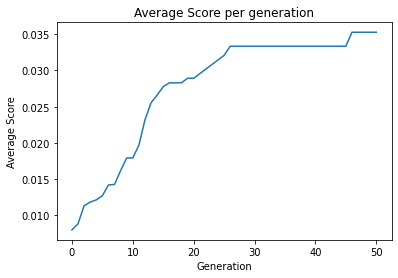

In [14]:
import matplotlib.pyplot as plt

if __name__ == "__main__":

  # Start population
  population = []

  for _ in range(10):
    population.append(Chromossome())

  generation = 0
  population_score = Problem.g_average(population)

  # Auxiliary variables for the plot
  generation_plot = [generation]
  population_score_plot = [population_score]

  # Performing iterations
  while generation < 50:
    parent1, parent2 = GeneticOperators.selection(population)

    GeneticOperators.crossover(population, parent1, parent2)
    GeneticOperators.mutation(population)
    GeneticOperators.elitism(population)

    generation += 1

    population_score = Problem.g_average(population)

    generation_plot.append(generation)
    population_score_plot.append(population_score)

    print(f"Generation #{generation} -> Average population score = {population_score:.3f}\n\n")

  best_chromossome = GeneticUtils.find_best_chromossome(population)
  print(f"Best individual: {GeneticUtils.format_chromossome(best_chromossome)}")

  plt.gca().set_xlabel("Generation")
  plt.gca().set_ylabel("Average Score")
  plt.gca().set_title("Average Score per generation")
  plt.plot(generation_plot, population_score_plot)
  plt.show()
